# Bees Detection with Amazon Sagemaker

### Table of contents
1. [Setup](#setup)
2. [Introduction to dataset](#introduction)
3. [Prepare the data for training](#preparation)
4. [Training an Object Detection model](#training)
5. [Deploing The Object Detection model](#deploying)
6. [Testing the Model](#testing)
7. [Cleanup](#cleanup)


<a name="setup"></a>

## Setup

In [3]:
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import json
import jsonlines
import numpy as np
import glob
import os
import matplotlib.patches as patches
from itertools import cycle
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
role = get_execution_role()
sess = sagemaker.Session()
BUCKET = sess.default_bucket()
PREFIX = 'input'

<a name="introduction"></a>
## Introduction to dataset
This dataset contains 500 images of bees that have been uploaded by inaturalist users for the purposes of recording the observation and identification. We only used images that their users have licensed under [CC0](https://creativecommons.org/share-your-work/public-domain/cc0/) license. For your convenience, we have placed the dataset in S3 in a single zip archive here: http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip 

First, download and unzip the archive.

In [5]:
!wget http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip 

--2021-04-17 07:48:25--  http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip
Resolving aws-tc-largeobjects.s3-us-west-2.amazonaws.com (aws-tc-largeobjects.s3-us-west-2.amazonaws.com)... 52.218.246.33
Connecting to aws-tc-largeobjects.s3-us-west-2.amazonaws.com (aws-tc-largeobjects.s3-us-west-2.amazonaws.com)|52.218.246.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70375947 (67M) [application/x-zip-compressed]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  67.12M  9.86MB/s    in 6.7s    

2021-04-17 07:48:32 (10.0 MB/s) - ‘dataset.zip’ saved [70375947/70375947]



In [6]:
#unzip the dataset
!unzip -qo dataset.zip -d ./dataset/

<a name="preparation"></a>

## Prepare the data for training

In [7]:
#upload images to S3 bucket
!aws s3 sync --exclude="*" --include="[0-9]*.jpg" ./dataset/ s3://$BUCKET/$PREFIX/

upload: dataset/10006450.jpg to s3://sagemaker-us-east-1-346561410819/input/10006450.jpg
upload: dataset/10250726.jpg to s3://sagemaker-us-east-1-346561410819/input/10250726.jpg
upload: dataset/10311147.jpg to s3://sagemaker-us-east-1-346561410819/input/10311147.jpg
upload: dataset/10022723.jpg to s3://sagemaker-us-east-1-346561410819/input/10022723.jpg
upload: dataset/10059108.jpg to s3://sagemaker-us-east-1-346561410819/input/10059108.jpg
upload: dataset/10551061.jpg to s3://sagemaker-us-east-1-346561410819/input/10551061.jpg
upload: dataset/1025450.jpg to s3://sagemaker-us-east-1-346561410819/input/1025450.jpg
upload: dataset/10437385.jpg to s3://sagemaker-us-east-1-346561410819/input/10437385.jpg
upload: dataset/1063563.jpg to s3://sagemaker-us-east-1-346561410819/input/1063563.jpg
upload: dataset/10299519.jpg to s3://sagemaker-us-east-1-346561410819/input/10299519.jpg
upload: dataset/10658023.jpg to s3://sagemaker-us-east-1-346561410819/input/10658023.jpg
upload: dataset/10631806.

In [8]:
#Create train.manifest and validation.manifest files

with jsonlines.open('./dataset/output.manifest', 'r') as reader:
    lines = list(reader)
    # Shuffle data in place.
    np.random.shuffle(lines)
    
dataset_size = len(lines)
num_training_samples = round(dataset_size*0.8)

train_data = lines[:num_training_samples]
validation_data = lines[num_training_samples:]

augmented_manifest_filename_train = 'train.manifest'

with open(augmented_manifest_filename_train, 'w') as f:
    for line in train_data:
        line['source-ref'] = line['source-ref'].replace("s3://sagemaker-remars/datasets/na-bees/500", "s3://{}/{}".format(BUCKET,PREFIX))
        f.write(json.dumps(line))
        f.write('\n')

augmented_manifest_filename_validation = 'validation.manifest'

with open(augmented_manifest_filename_validation, 'w') as f:
    for line in validation_data:
        line['source-ref'] = line['source-ref'].replace("s3://sagemaker-remars/datasets/na-bees/500", "s3://{}/{}".format(BUCKET,PREFIX))
        f.write(json.dumps(line))
        f.write('\n')
        
print(f'training samples: {num_training_samples}, validation samples: {len(lines)-num_training_samples}')

training samples: 400, validation samples: 100


In [9]:
#upload manifest files on S3

pfx_training = PREFIX + '/training' if PREFIX else 'training'
# Defines paths for use in the training job request.
s3_train_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_train)
s3_validation_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_validation)

!aws s3 cp train.manifest s3://$BUCKET/$pfx_training/
!aws s3 cp validation.manifest s3://$BUCKET/$pfx_training/

upload: ./train.manifest to s3://sagemaker-us-east-1-346561410819/input/training/train.manifest
upload: ./validation.manifest to s3://sagemaker-us-east-1-346561410819/input/training/validation.manifest


<a name='training'></a>
## Training an Object Detection Model

In [15]:
#get an image from object detection algorithm
training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [16]:
# defining the input and the validation data
training_data = sagemaker.session.s3_input(
                                        s3_train_data_path,
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'bees-500'],
                                        record_wrapping='RecordIO') 

validation_data = sagemaker.session.s3_input(
                                        s3_validation_data_path,
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'bees-500'],
                                        record_wrapping='RecordIO')

data_channels = {'train': training_data, 'validation': validation_data}

s3_output_location = "s3://{}/{}/training/output/".format(BUCKET,PREFIX)

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [17]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         input_mode= 'Pipe',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [21]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=1,
                             mini_batch_size=1,
                             epochs=100,
                             learning_rate=0.001,
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=300,
                             label_width=350,
                             num_training_samples=400,
                             early_stopping=True,
                             early_stopping_min_epochs=50,
                             early_stopping_patience=5,
                             early_stopping_tolerance=0.01
                            )

In [22]:
od_model.fit(inputs=data_channels, logs=True)

2021-04-17 08:27:15 Starting - Starting the training job...
2021-04-17 08:27:17 Starting - Launching requested ML instancesProfilerReport-1618648035: InProgress
.........
2021-04-17 08:29:03 Starting - Preparing the instances for training......
2021-04-17 08:30:08 Downloading - Downloading input data
2021-04-17 08:30:08 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
[04/17/2021 08:31:03 INFO 140414838699200] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optim

<a name="deploying"></a>

## Deploing The Object Detection model

In [24]:
#make an endpoint
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

---------------!

<a name="testing"></a>

## Testing the Model

In [25]:
#geting the test images
test_images = glob.glob('dataset/test/*')
print(*test_images, sep="\n")

dataset/test/23086755.jpg
dataset/test/22775000.jpg
dataset/test/22741822.jpg
dataset/test/22901964.jpg
dataset/test/22427594.jpg
dataset/test/22469656.jpg
dataset/test/22544384.jpg
dataset/test/22971237.jpg
dataset/test/22774999.jpg
dataset/test/22673445.jpg


In [26]:
#function to draw the predection box
def prediction_to_bbox_data(image_path, prediction):
    class_id, confidence, xmin, ymin, xmax, ymax = prediction
    width, height = Image.open(image_path).size
    bbox_data = {'class_id': class_id,
               'height': (ymax-ymin)*height,
               'width': (xmax-xmin)*width,
               'left': xmin*width,
               'top': ymin*height}
    return bbox_data

In [31]:
#function to draw the image with the predection box
def show_annotated_image(img_path, bboxes):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    colors = cycle(['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'])
    
    for bbox in bboxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox['left'],bbox['top']),bbox['width'],bbox['height'],linewidth=1,edgecolor=next(colors),facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

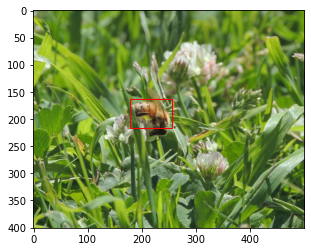

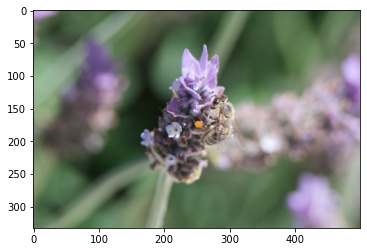

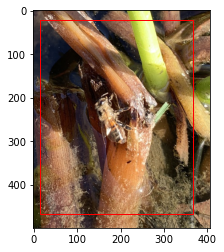

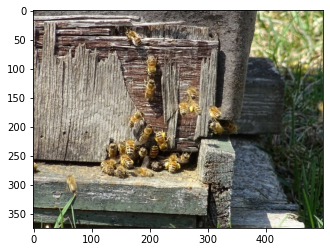

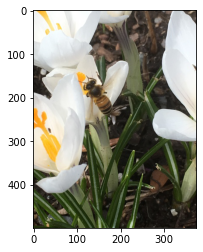

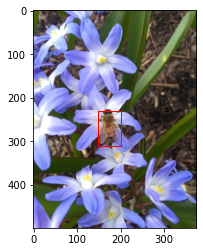

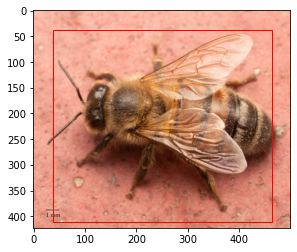

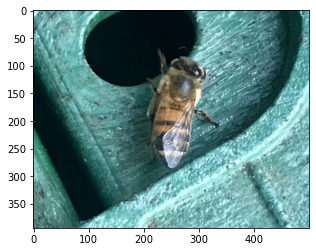

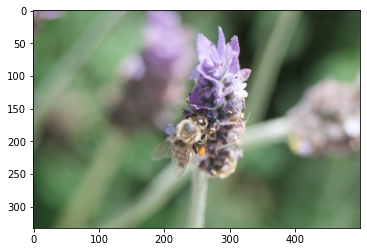

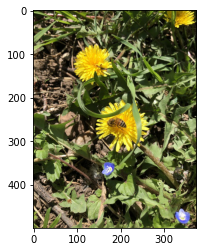

In [32]:
endpoint_name=object_detector.endpoint_name
client = boto3.client('sagemaker')
runtime_client = boto3.client('sagemaker-runtime')

# Call SageMaker endpoint to obtain predictions
def get_predictions_for_img(runtime_client, endpoint_name, img_path):
    with open(img_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)

    result = response['Body'].read()
    result = json.loads(result)
    return result


# wait until the status has changed
client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
if status != 'InService':
    raise Exception('Endpoint creation failed.')

for test_image in test_images:
    result = get_predictions_for_img(runtime_client, endpoint_name, test_image)
    confidence_threshold = .5
    best_n = 1
    # display the best n predictions with confidence > confidence_threshold
    predictions = [prediction for prediction in result['prediction'] if prediction[1] > confidence_threshold]
    predictions.sort(reverse=True, key = lambda x: x[1])
    bboxes = [prediction_to_bbox_data(test_image, prediction) for prediction in predictions[:best_n]]
    show_annotated_image(test_image, bboxes)

<a name='cleanup'></a>
## Cleanup

At the end we would like to delete the real-time endpoint, as keeping a real-time endpoint around while being idle is costly and wasteful. 

In [33]:
client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '3bf29dc2-0393-4721-b086-f44f399b9c58',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3bf29dc2-0393-4721-b086-f44f399b9c58',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 17 Apr 2021 09:18:37 GMT'},
  'RetryAttempts': 0}}